In [13]:
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import pickle

df_road = pd.read_csv('../database/data/road.csv')
df_rel = pd.read_csv("../database/data/rel.csv")

num_road = df_road['id'].count()
num_rel = df_rel['id'].count()

原始特征编码方法：
+ highway type, 独热码，如果这一项缺失，就用它所在的小块中所拥有的类型中选择一个最大的(因为比较主干的路一般不会缺失highway) （这样是13维）
+ degree embedding, 节点度的embedding编码，用(sin 2^0d, sin 2^1d, sin 2^2d...), 暂定弄到8维.
+ density embedding, 道路空间密度，为了方便计算，预定义一些小格，把路段分到这些小格中，用每个小格中有的路段数量除以小格面积当作这个小格中路段的近似密度；路段只以起点和终点计入网格中，如果起点和中点在两个不同的格，就同时记入两个网格中，其密度用两个网格密度的平均. 同样也用正弦或者余弦嵌入编码一下，暂定弄到8维，这样一共就是29维.

先试一下看看效果.

In [4]:
# 网格范围.
west_bound = 1000
east_bound = 0
north_bound = 0
south_bound = 1000
for idx, road in df_road.iterrows():
    coord = ast.literal_eval(road[1])
    for point in coord:
        if point[0] < west_bound:
            west_bound = point[0]
        if point[0] > east_bound:
            east_bound = point[0]
        if point[1] < south_bound:
            south_bound = point[1]
        if point[1] > north_bound:
            north_bound = point[1]
print("north: {}, south: {}, west: {}, east: {}".format(north_bound, south_bound, west_bound, east_bound))

C:\Users\admin\AppData\Local\Temp\ipykernel_28928\3590916984.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = ast.literal_eval(road[1])


north: 40.0006224, south: 39.7955236, west: 116.2500662, east: 116.5018476


0.007193754285714249 0.007324957142856954


C:\Users\admin\AppData\Local\Temp\ipykernel_28928\1796705185.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord = ast.literal_eval(road[1])


383.0 3.0


(array([2651., 7555., 8760., 7909., 4866., 3594.,  794., 1054.,  177.,
         667.]),
 array([  3.,  41.,  79., 117., 155., 193., 231., 269., 307., 345., 383.]),
 <BarContainer object of 10 artists>)

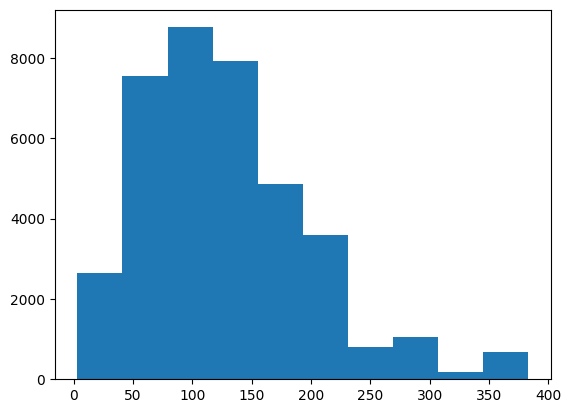

In [11]:
grid_x = 35   # 东西向
grid_y = 28   # 大概1度600米范围..
grid_x_range = (east_bound - west_bound) / grid_x
grid_y_range = (north_bound - south_bound) / grid_y
print(grid_x_range, grid_y_range)
grid = np.zeros((grid_x, grid_y))
road_in = np.zeros((num_road, 2))
road_intensity = np.zeros((num_road))
for idx, road in df_road.iterrows():
    coord = ast.literal_eval(road[1])
    for i in [0, -1]:  # 起点终点
        point = coord[i]
        x_val = int(np.floor((point[0] - west_bound) / grid_x_range))
        y_val = int(np.floor((point[1] - south_bound)/ grid_y_range))
        grid[x_val, y_val] += 1
        road_in[idx,i] = x_val * grid_x + y_val
for idx in range(num_road):
    start_block = road_in[idx,0]
    end_block = road_in[idx, 1]
    start_num = grid[int(start_block//grid_x), int(start_block%grid_x)]
    end_num = grid[int(end_block//grid_x), int(end_block%grid_x)]
    average_num = (start_num + end_num) / 2
    road_intensity[idx] = average_num   # 这里的单位面积大约是600m*600m.

print(road_intensity.max(), road_intensity.min())
plt.hist(road_intensity)

C:\Users\admin\AppData\Local\Temp\ipykernel_28928\1280357664.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  origin_id = int(rel[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_28928\1280357664.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_id = int(rel[2])


0.0 11.0


(array([4.8000e+01, 2.4220e+03, 3.2640e+03, 8.4190e+03, 6.1870e+03,
        1.2723e+04, 4.0640e+03, 8.7000e+02, 2.0000e+01, 1.0000e+01]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

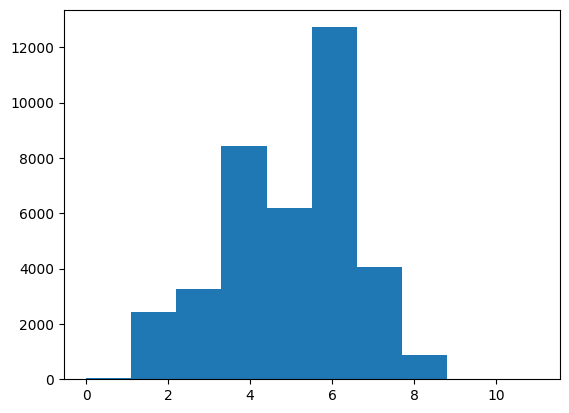

In [12]:
# 计算度，degree.
degree = np.zeros((num_road))
for idx, rel in df_rel.iterrows():
    origin_id = int(rel[1])
    target_id = int(rel[2])
    degree[origin_id] += 1
    degree[target_id] += 1
print(degree.min(), degree.max())
plt.hist(degree)

In [14]:
degree_dim = 8
intensity_dim = 8
num_highway = 13
n_features = num_highway + 1 + degree_dim + 1 + intensity_dim

highway_code = np.zeros((num_road, num_highway))
for idx, road in df_road.iterrows():
    highway = int(road[2])
    if highway != 0:
        highway_code[idx, highway-1] = 1

degree_embd = np.zeros((num_road, degree_dim))
first = True
for i in range(degree_dim):
    if first:
        tmp = degree
        first = False
    else:
        tmp = 2 * tmp
    degree_embd[:, i] = np.sin(tmp)

intensity_embd = np.zeros((num_road, intensity_dim))
first = True
for i in range(intensity_dim):
    if first:
        tmp = road_intensity
        first = False
    else:
        tmp = 2 * tmp
    intensity_embd[:,i] = np.sin(tmp)

road_features = np.float32(np.concatenate((highway_code, degree[:,np.newaxis], degree_embd, road_intensity[:,np.newaxis], intensity_embd), axis=1))
print(road_features.shape)
with open("road_features.pkl", "wb") as f:
    pickle.dump(road_features, f)

C:\Users\admin\AppData\Local\Temp\ipykernel_28928\3695784716.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highway = int(road[2])


(38027, 31)


下面预处理traj. 取出有效的traj, 其轨迹的路段编号数组(opath)，其起点和终点的坐标(注意是匹配后的点.)，其起点和终点的速度... (先不求每个路段上的平均速度来做约束了,...看看效果先.)
它将作为数据集使用.
注意，这里导出的轨迹信息将作为数据集使用，其id和原本的traj_id并不对应(没有考虑跳过的情况.), 但是有一个单独的traj_id的域.

数据集中每一项是一个元组：  
**( traj_id, 起始点在路径上对应的匹配点的位置，终点在路径上对应的匹配点的位置，起始点的速度，终点的速度，路径中每个路段的id )**

In [20]:
# cpath: 需要的路径(编号.). opath, 每个点匹配到的路段的编号.
df_traj_raw = pd.read_csv("../database/data/traj.csv")
df_traj = pd.read_csv("../database/fmm/fmm_all_fields.csv", delimiter=";")

# 每个轨迹的起点和终点速度.
start_end_speed = {}  # tid->speeds
traj_id = -1
speeds = np.zeros((2))
for idx, raw_traj in df_traj_raw.iterrows():
    tid = raw_traj['traj_id']
    speed = raw_traj['speeds']
    if traj_id != tid:
        if traj_id != -1:
            start_end_speed[traj_id] = speeds
        traj_id = tid
        speeds = np.array([speed, speed])
    else:
        speeds[1] = speed
start_end_speed[traj_id] = speeds

def ParseLineString(linestring:str, idx:list = None):
    '''
    按照idx列表中指定的索引返回一个数组，里面每个元素是代表一个点的长度为2的list，idx为None则按顺序返回所有点形成的list.
    '''
    nums_str = linestring[11:-1]
    points_str = nums_str.split(',')
    if idx is None:
        ret = map(lambda s: ast.literal_eval('[{}]'.format(s.replace(' ', ',', 1))), points_str)
    ret = [ast.literal_eval('[{}]'.format(points_str[i].replace(' ', ',', 1))) for i in idx]
    return ret


total_traj_num = df_traj['id'].count()
valid = 0
traj_data = []
for idx, traj in df_traj.iterrows():
    tid = traj['id']
    try:
        road_path_ids = ast.literal_eval('[{}]'.format(traj['cpath']))
    except:
        continue   # [nan]，没有数据，没有匹配成功
    if len(road_path_ids) == 0:
        continue
    start_end_matched_points = ParseLineString(traj['pgeom'], [0, -1])
    speeds = start_end_speed[tid]
    entry = (tid, start_end_matched_points[0], start_end_matched_points[1], speeds[0], speeds[1], road_path_ids)
    traj_data.append(entry)
    valid += 1

traj_data.sort(key=lambda x: x[0])
print("{} trajs in total, {} is successfully matched.".format(total_traj_num, valid))
with open("traj_data.pkl", "wb") as f:
    pickle.dump(traj_data, f)

17600 trajs in total, 16967 is successfully matched.
